In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import grid
from itertools import product

In [2]:
pois=pd.read_csv("pois.csv",sep=" ")

In [3]:
pois["poi_id"].duplicated().any()

False

In [5]:
# Client-side protection
def defense(lat,lon,param=1):
    """param is the penalization exponent for the utility"""
    # Get the current indices that the user is in
    i,j=grid.location_to_cell_indices(lat,lon)
    # Get all possible indices of the grids
    all_indices=product(range(1,grid.CELL_NUM_LAT+1),range(1,grid.CELL_NUM_LON+1))
    # Get the Euclidian distance of the current location to other indices
    distance=np.zeros(100)
    for index,item in enumerate(all_indices):
        distance[index]=np.sqrt((item[0]-i)**2 + (item[1]-j)**2)
    # Define the utility as 1/(1+distance)**param to avoid dividing by zero
    utility=1/(1+distance)**param
    # Normalize the probabilities
    probabilities=utility/np.sum(utility)
    # Choose the indices w.r.t. these probabilities
    choice=np.random.choice(np.arange(100),p=probabilities)
    # Get the private indices after applying the defense mechanism
    i_private,j_private=choice//10+1,choice%10+1
    # Return the representative coordinates for the grid. This is what the client will request from the server.
    # print(i,j)
    # print(i_private,j_private)
    # print(grid.location_to_cell_representative(lat,lon))
    return grid.index_to_cell_representative(i_private-1,j_private-1)

defense(46.568819955744104,6.64294176710424,param=10)

(46.566500000000005, 6.645)

In [6]:
# Apply the defense mechanism to queries.csv
queries=pd.read_csv("queries.csv",sep=" ")
queries.head(5)

,ip_address,lat,lon,timestamp,poi_type_query
0,34.101.177.245,46.532942,6.591174,14.912448,cafeteria
1,34.101.177.245,46.532942,6.591174,14.912448,restaurant
2,34.101.177.245,46.550342,6.602852,18.024657,restaurant
3,34.101.177.245,46.550342,6.602852,18.024657,cafeteria
4,34.101.177.245,46.532942,6.591174,36.334539,cafeteria


In [12]:
"lat" in queries.columns

True

In [16]:
queries["new"]=queries.apply(lambda x: defense(x["lat"],x["lon"],param=1),axis=1)
queries["lat"]=queries["new"].map(lambda x: x[0])
queries["lon"]=queries["new"].map(lambda x: x[1])
queries=queries.drop("new",axis=1)
queries.head(5)

,ip_address,lat,lon,timestamp,poi_type_query
0,34.101.177.245,46.5595,6.585,14.912448,cafeteria
1,34.101.177.245,46.5665,6.585,14.912448,restaurant
2,34.101.177.245,46.5595,6.575,18.024657,restaurant
3,34.101.177.245,46.5385,6.585,18.024657,cafeteria
4,34.101.177.245,46.5525,6.615,36.334539,cafeteria


In [17]:
# Apply the attack here
# %%
# Imports
import pandas as pd
import grid
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from colorsys import hsv_to_rgb
import numpy as np


# %%
# Helper Classes

class User:
    def __init__(self, ip, queries, home, work, lunch, sports, social):
        self.ip = ip
        self.queries = queries
        self.home = home
        self.work = work
        self.lunch = lunch
        self.sports = sports
        self.social = social

    def plot(self):
        plt.plot(self.queries.lat, self.queries.lon, zorder=0)
        plt.scatter(self.queries.lat, self.queries.lon,
                    c=self.queries.timestamp % 24, cmap="hsv", vmin=0, vmax=24)  # type:ignore

        plt.plot([self.home.lat], [self.home.lon], color=(
            1, 0, 0), marker="*", markersize=20, zorder=1)
        plt.plot([self.work.lat], [self.work.lon], color=(
            0, 1, 0), marker="*", markersize=20, zorder=1)

        plt.colorbar()
        plt.title(self.ip)
        plt.show()


# %%
class PoiWeighter:
    def __init__(self, name, poi_types, peak_center, peak_narrowness, min_weight):
        self.name = name
        self.poi_types = poi_types
        self.weight_fun = lambda x: np.sin(
            (x - 12 - peak_center) * np.pi/24) ** peak_narrowness * (1-min_weight) + min_weight


weighters = [
    PoiWeighter(
        "home",
        ["appartment_block", "villa"],
        0, 2, 1/4
    ),
    PoiWeighter(
        "work",
        ["office", "laboratory", "company"],
        12, 4, 0
    ),
    PoiWeighter(
        "lunch",
        ["restaurant", "cafeteria"],
        12, 100, 0
    ),
    PoiWeighter(
        "sports",
        ["gym", "dojo"],
        16, 20, 1/4
    ),
    PoiWeighter(
        "social",
        ["restaurant", "bar", "club"],
        22, 20, 0
    )
]


# %%
def subtraction_matrix(v1, v2):
    v1 = v1.repeat(len(v2)).reshape(len(v1), len(v2))
    v2 = v2.repeat(len(v1)).reshape(len(v2), len(v1)).T
    return v1 - v2


# %%
# Load Data
queries["cell_id"] = queries.apply(
    lambda l: grid.location_to_cell_id(l.lat, l.lon), axis=1)
queries["time_of_day"] = queries.apply(lambda l: l.timestamp % 24, axis=1)

pois = pd.read_csv("pois.csv", sep=" ")
pois["cell_id"] = pois.apply(
    lambda l: grid.location_to_cell_id(l.lat, l.lon), axis=1)

for weighter in weighters:
    queries[f"weight_{weighter.name}"] = weighter.weight_fun(
        queries.time_of_day)

# %%
# Calculate Distances from each query to each poi
delta_lat = subtraction_matrix(
    queries.lat.to_numpy(),
    pois.lat.to_numpy()
)

delta_lon = subtraction_matrix(
    queries.lon.to_numpy(),
    pois.lon.to_numpy()
)

# Distances in degrees
distances = np.sqrt(delta_lat**2 + delta_lon**2)

# See https://www.desmos.com/calculator/dlzawknavh
# Scores: distance 0 -> score 1, distance 100 -> score 0.25
quarter_distance = 100  # At what distance (m) the score should be 0.25
scores = 1/(1 + distances * (78348/quarter_distance))**2

0.98.248.97


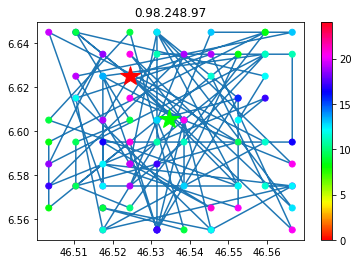

10.229.150.53


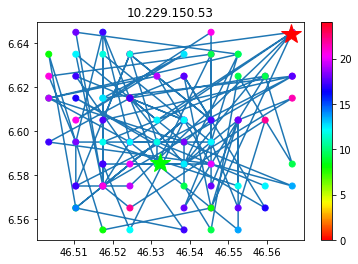

100.255.65.73


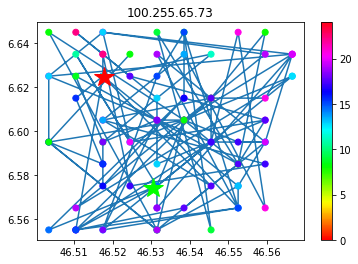

101.193.212.180


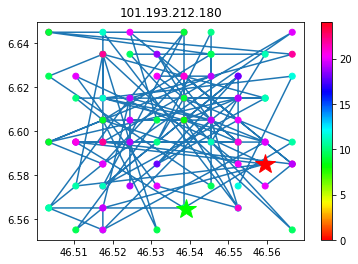

103.107.27.105


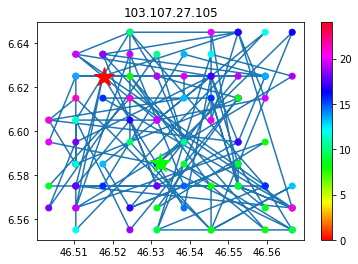

103.75.228.13


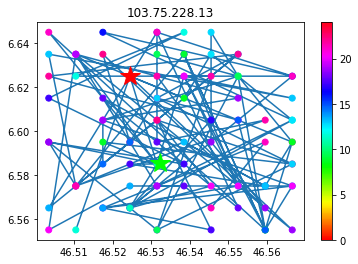

104.149.206.168


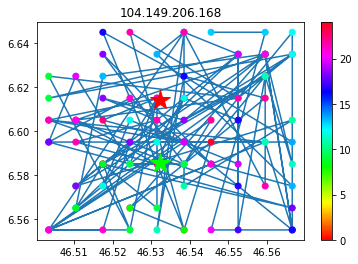

105.148.239.144


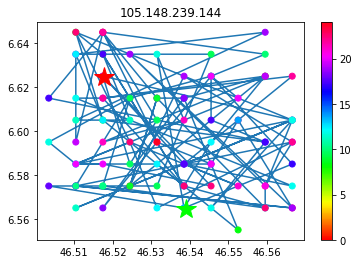

106.44.169.163


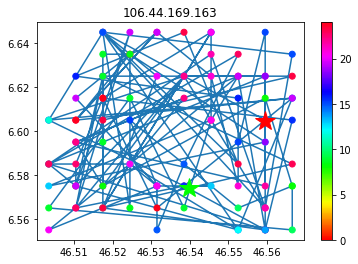

107.201.148.122


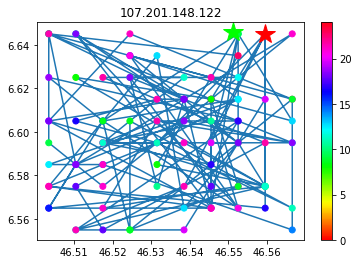

11.105.81.179


KeyboardInterrupt: 

In [18]:
# %%
#users = pd.DataFrame()
#poi_scores = {str(poi_type): scores[:, pois.poi_type == poi_type] for poi_type in pois.poi_type.unique()}
# Instantiate classes
for ip, user_data in queries.groupby("ip_address"):
    user_scores = scores[user_data.index]
    user_scored_pois = pois.copy()
    topscorers = {}
    for weighter in weighters:
        weights = weighter.weight_fun(
            user_data.time_of_day).to_numpy().reshape(-1, 1)
        weighted_pois = pd.concat(
            user_scored_pois[user_scored_pois.poi_type == poi_type] for poi_type in weighter.poi_types)
        weighted_scores = user_scores[:, weighted_pois.index] * weights
        weighted_pois[f"score"] = weighted_scores.sum(axis=0) / len(user_data)
        best_index = weighted_pois.score.idxmax()
        topscorers[weighter.name] = weighted_pois.loc[best_index]

    user = User(ip, user_data, topscorers["home"], topscorers["work"],
                topscorers["lunch"], topscorers["sports"], topscorers["social"])
    print(ip)
    user.plot()